### SUPERMARKET SIMULATION

Simulation and visualization of customer behaviour in a supermarket, based on data analysis and calculation of transition probabilties using Markov chain. 
It also has an additional feature where there is a limit to the customers that can be in a section. If anyone of the sections are filled, customers will be directed to another section. This is done to introduce the COVID-19 factor into the simulation.


Process:
1. Read data from the .csv files and create a transition matrix
2. Use the transition matrix and simulate all movements of the customers using Markov Chain

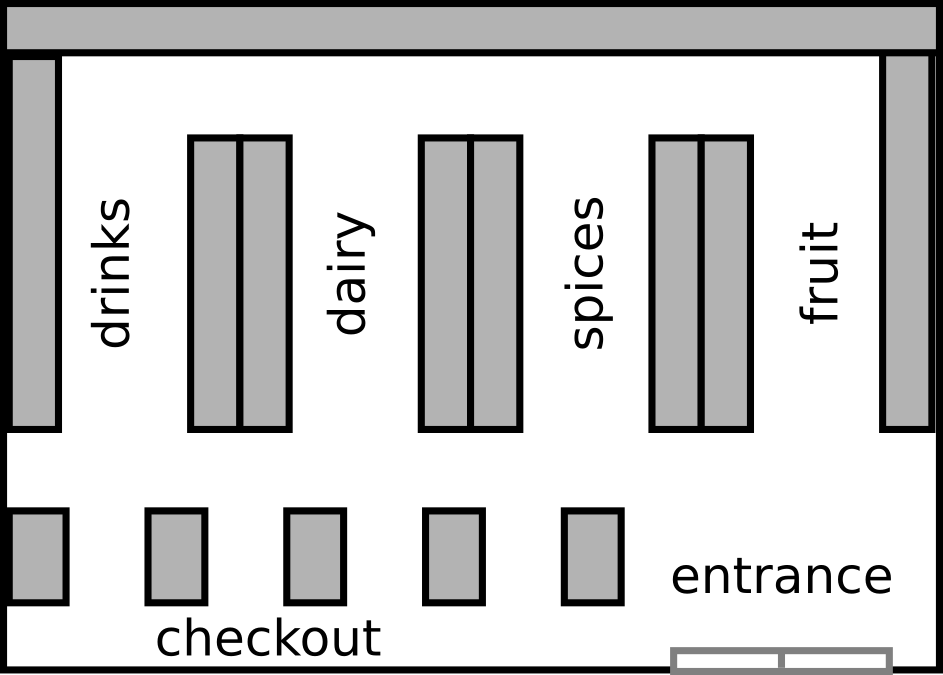

In [1]:
from IPython.display import Image
Image(filename = "market.png")

In [2]:
# Importing the required Libraries
import pandas as pd
import numpy as np
import cv2
import time
import pygraphviz as pgv
import time

In [3]:
# Reading an image which will be later used in Visualisation
cust_height = 30
cust_width = 30
img = cv2.imread('market.png')
img.shape

(675, 943, 3)

In [4]:
# Reading the calculated Transition and Entry Probabilitites
transition_probs = pd.read_csv("probabilities.csv", index_col=0)
probabilities_entry = pd.read_csv("probabilities_entry.csv", index_col=0)
probabilities_entry
transition_probs

,checkout,dairy,drinks,fruit,spices
dairy,0.391211,0.000000,0.223151,0.189925,0.195713
drinks,0.537023,0.027159,0.000000,0.219062,0.216756
fruit,0.499511,0.238319,0.136266,0.000000,0.125904
spices,0.251000,0.323553,0.273140,0.152307,0.000000
checkout,1.000000,0.000000,0.000000,0.000000,0.000000


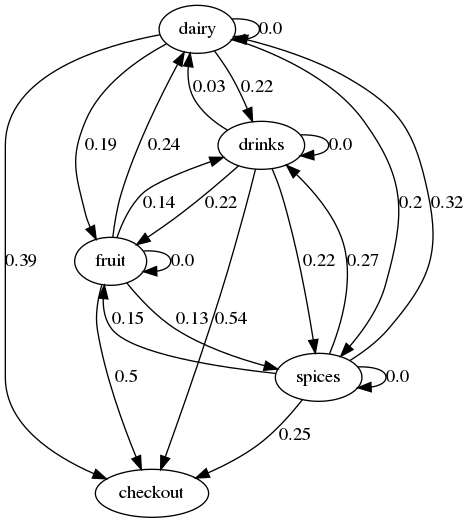

In [5]:
# Plotting the Transitional Probability Matrix as a directed graph
locations = ["dairy", "drinks", "fruit", "spices", "checkout"]
G = pgv.AGraph(directed=True)
for start_location in locations[:-1]:
    for end_location in locations:
        G.add_edge(
            start_location,
            end_location,
            label=np.round(transition_probs.loc[start_location, end_location], 2),
        )

G.draw("transition.png", prog="dot")
Image(filename = "transition.png")

### SUPERMARKET CLASS

The main feature of this class is to allot each section in the supermarket it's place in the 2 dimensional array. It also has a fixed number of slots in each section and when those slots are filled by customers, they are asked to move to another section.

In [6]:
#MARKET 
class Market:
    def __init__(self):
        self.positions = {"entrance" : np.array([730, 770]), "fruit" : np.array([370, 790]),\
            "spices" : np.array([370, 580]), "dairy" : np.array([370, 350]), "drinks" :\
            np.array([370, 120]), "checkout1" : np.array([560, 110]), "checkout2" :\
             np.array([560, 240]), "checkout3" : np.array([560, 380]), "checkout4" : np.array([560, 520])}

        self.slots = {'dairy': set(), 'drinks': set(), 'entrance': set(), 'checkout1': set(),\
          'checkout2': set(), 'checkout3': set(), 'checkout4': set(), "fruit": set(), "spices": set()}

### CUSTOMER CLASS

This is the most important class in this program. It uses Markov Chain to calculate the probabilities from the entrance to exit and changes the state of a customer based on these probabilities. It also takes care when the slots are filled in a section by moving customers from one section to another.

In [7]:
#CUSTOMER
class Customer:
    def __init__(self, name, current_state, color):
        self.name = name
        self.current_state = "entrance"#initial stage
        self.color = color

        self.market_pos = np.array([730, 770])#starting at the entrance
        self.differ = None
        self.velocity = 1 #speed at which the customers are moving
        self.x_reached = None
        self.y_reached = None
        self.next_state = None
        self.reached_state = True
        self.deviation = np.array([0, 0])
        self.slot = ""

        self.waiting = False
        self.original_waiting_duration = 100 
        self.waiting_duration = self.original_waiting_duration

    # Changing states frome entrance to exit    
    def move(self):
        if self.reached_state == True:  # Choosing the section at entrance
            if self.current_state == "entrance":
                while True:                         # find next (first) section, special trans matrix, directly after entrance
                    rand_nr = np.random.random()
                    rand_index = np.random.choice(probabilities_entry.index)
                    prob = probabilities_entry.loc[rand_index].values
                    if rand_nr > (1-prob):
                        self.next_state = rand_index
                        break
            else:
                while True: # Finding the next state
                    rand_nr = np.random.random()
                    rand_col = np.random.choice(transition_probs.columns)
                    prob = transition_probs.loc[self.current_state, rand_col]
                    if rand_nr > (1-prob):
                        self.next_state = rand_col
                        break

            if self.next_state == "checkout": # Checkout
                # find nearest counter on the x-axis and set this as next_state
                checkout_distance_x = abs((self.market_pos - m.positions["checkout1"])[1])
                nearest_checkout = "checkout1"
                for i in ["checkout1", "checkout2", "checkout3", "checkout4"]:
                    if abs((self.market_pos - m.positions[i])[1]) < checkout_distance_x:
                        checkout_distance_x = abs((self.market_pos - m.positions[i])[1])
                        nearest_checkout = i
                self.next_state = nearest_checkout
            self.differ = self.market_pos - m.positions[self.next_state]
            self.slot = ""

        self.waiting = False
        self.reached_state = False
        self.x_reached = False
        self.y_reached = False

        # Update section position and difference to the next stage
        if self.differ[0] > 0:
            self.market_pos[0] = self.market_pos[0] - self.velocity     
            self.differ = self.market_pos - m.positions[self.next_state] + self.deviation   
        elif self.differ[0] < 0:
            self.market_pos[0] = self.market_pos[0] + self.velocity
            self.differ = self.market_pos - m.positions[self.next_state] + self.deviation
        elif self.differ[0] == 0:
            self.x_reached = True


        if self.differ[1] > 0:
            self.market_pos[1] = self.market_pos[1] - self.velocity
            self.differ = self.market_pos - m.positions[self.next_state] + self.deviation
        elif self.differ[1] < 0:
            self.market_pos[1] = self.market_pos[1] + self.velocity
            self.differ = self.market_pos - m.positions[self.next_state] + self.deviation
        elif self.differ[1] == 0:
            self.y_reached = True

    # Changing sections when the slots in one of the sections is full
        if (abs(self.differ.sum()) < (2*self.velocity)) and self.slot == "":

            if len(m.slots[self.next_state]) == 0:
                m.slots[self.next_state].add("a")
                self.slot = "a"
                dev = 0
            else:
                if "a" not in m.slots[self.next_state]:
                    m.slots[self.next_state].add("a")
                    self.slot = "a"
                    dev = 1
                elif "b" not in m.slots[self.next_state]:
                    m.slots[self.next_state].add("b")
                    self.slot = "b"
                    dev = 2
                elif "c" not in m.slots[self.next_state]:
                    m.slots[self.next_state].add("c")
                    self.slot = "c"
                    dev = 3
                elif "d" not in m.slots[self.next_state]:
                    m.slots[self.next_state].add("d")
                    self.slot = "d"
                    dev = 4
                elif "e" not in m.slots[self.next_state]:
                    m.slots[self.next_state].add("e")
                    self.slot = "e"
                    dev = 5
                else:
                    m.slots[self.next_state].add("f")
                    self.slot = "f"
                    dev = 6

            self.deviation = np.array([ dev*30, 0])
            self.x_reached = False
            self.y_reached = False

        if self.x_reached and self.y_reached:
            self.reached_state = True
            self.waiting = True
            self.current_state = self.next_state
            #m.slots[self.current_state].append(self.slot)
            
    # Customers wait while checking out if there are customers already present in the queue
    def wait(self):
        m.slots[self.current_state].add(self.slot)
        self.waiting_duration = self.waiting_duration - 1
        if self.waiting_duration == 0:
            self.waiting = False
            self.waiting_duration = self.original_waiting_duration
            m.slots[self.current_state].remove(self.slot)


### VISUALISING THE SIMULATION

This section visualises the simulation. Here, each customer will be represented as a colored square and based on the time at which they've entered, they will be assigned one of the 3 colors - yellow, pink, blue. And based on the calculated probabilities at each stage, their path is determined. 

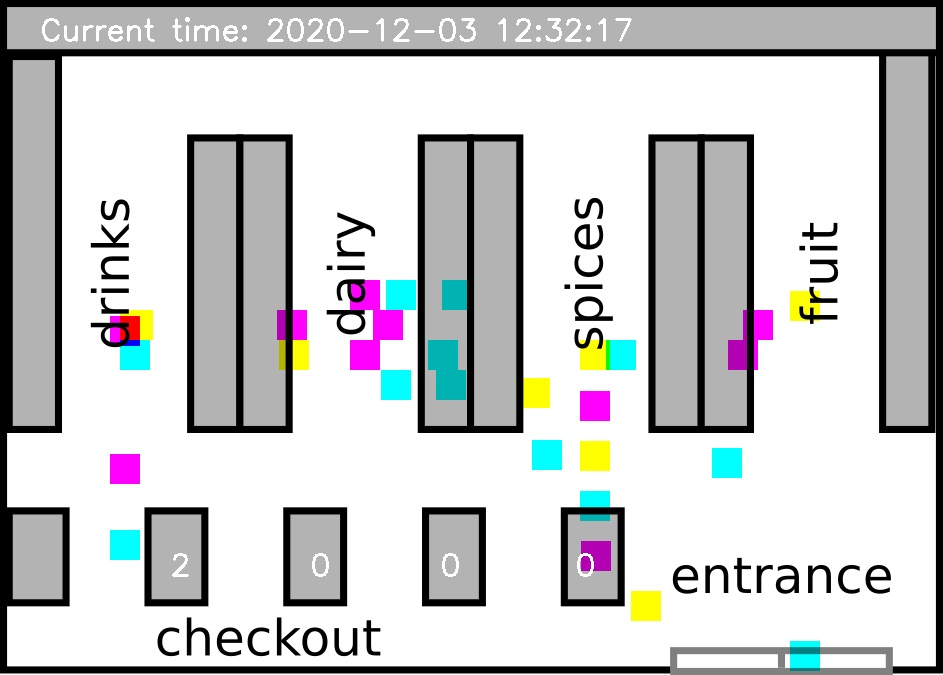

In [8]:
#Visualising the simulation

t_end = time.time() + 60 * 1

# timestamp printed on screen
font = cv2.FONT_HERSHEY_SIMPLEX
clock_lowerLeftCornerOfText = (40,40)
counter4_lowerLeftCornerOfText = (575,575)
counter3_lowerLeftCornerOfText = (440,575)
counter2_lowerLeftCornerOfText = (310,575)
counter1_lowerLeftCornerOfText = (170,575)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

current_time = pd.to_datetime("2020-12-03 09:00:00")
active_customers = []
m = Market()
i = 0

#Simlation runs for a minute
while time.time() < t_end:
    i += 1
    frame = img.copy()

    cv2.putText(frame, f"Current time: {current_time}",
        clock_lowerLeftCornerOfText,
        font,
        fontScale,
        fontColor,
        lineType)

    color = (i%3)  # alotting colors to represent customers, 0 = yellow, 1= pink, 2=blue
    if (i%50) == 0: # allows only 50 customers at once
        c = Customer(f"customer{i}", "entrance", color)
        active_customers.append(c)

    for j, cust in enumerate(active_customers):
        if cust.waiting == True:
            cust.wait()
        else:
            cust.move()

        frame[cust.market_pos[0] : cust.market_pos[0] + cust_height, cust.market_pos[1] : cust.market_pos[1] + cust_width, cust.color] = 0.0

        if cust.reached_state == True and cust.current_state in ["checkout1", "checkout2", "checkout3", "checkout4"]:
            if cust.waiting == True:
                cust.wait()
            else:
                del active_customers[j]

    ch4 = len(m.slots["checkout4"])
    ch3 = len(m.slots["checkout3"])
    ch2 = len(m.slots["checkout2"])
    ch1 = len(m.slots["checkout1"])

    cv2.putText(frame, f"{ch4}",
        counter4_lowerLeftCornerOfText,
        font,
        fontScale,
        fontColor,
        lineType)
    cv2.putText(frame, f"{ch3}",
        counter3_lowerLeftCornerOfText,
        font,
        fontScale,
        fontColor,
        lineType)
    cv2.putText(frame, f"{ch2}",
        counter2_lowerLeftCornerOfText,
        font,
        fontScale,
        fontColor,
        lineType)
    cv2.putText(frame, f"{ch1}",
        counter1_lowerLeftCornerOfText,
        font,
        fontScale,
        fontColor,
        lineType)

    cv2.imshow('Output', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
    current_time = current_time + pd.Timedelta("1 seconds")

cv2.imwrite("output.jpg", frame)     # save frame as JPEG file
Image(filename = "output.jpg")
    

### FUTURE WORK

1. Add revenue and calculate the most profitable/in demand section and dynamically keep adding in new places in the shop to keep up with the demand.
2. Print the available stock in the warehouse after evry couple of hours
3. Introduce social distancing among the customers and see how that affects the business 